In [1]:
import os

def count_images(path):
    exts = {".png", ".jpg", ".jpeg", ".webp"}
    count = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            if os.path.splitext(f.lower())[1] in exts:
                count += 1
    return count

real_count = count_images("/kaggle/input/human-faces/real_images/content/dataset/real_images")
fake_count = count_images("/kaggle/input/human-faces/fake_images/content/dataset/fake_images")

print("Real images:", real_count)
print("Fake images:", fake_count)
print("Total:", real_count + fake_count)

Real images: 10000
Fake images: 10000
Total: 20000


In [2]:
import os
import glob
import random
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# Paths
DATA_DIR = '/kaggle/input/human-faces'
REAL_DIR = os.path.join(DATA_DIR, 'real_images')
FAKE_DIR = os.path.join(DATA_DIR, 'fake_images')

# Image transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class ImageFolderWithLabel(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)
        # Ensure 'Real' = 0, 'Fake' = 1
        self.class_to_idx = {'real_images': 0, 'fake_images': 1}

# Combine datasets
all_data = ImageFolderWithLabel(DATA_DIR, transform=transform_train)

In [4]:
train_size = int(0.8 * len(all_data))
test_size = len(all_data) - train_size
train_dataset, test_dataset = random_split(all_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s] 


In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch [1/5], Loss: 0.2271
Epoch [2/5], Loss: 0.0783
Epoch [3/5], Loss: 0.0529
Epoch [4/5], Loss: 0.0357
Epoch [5/5], Loss: 0.0360


Accuracy:  0.9770
Precision: 0.9787
Recall:    0.9748
F1-score:  0.9768


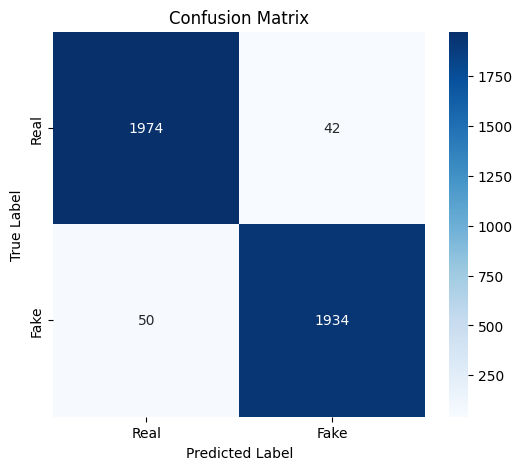

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    labels = ["Real", "Fake"]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


evaluate_model(model, test_loader)

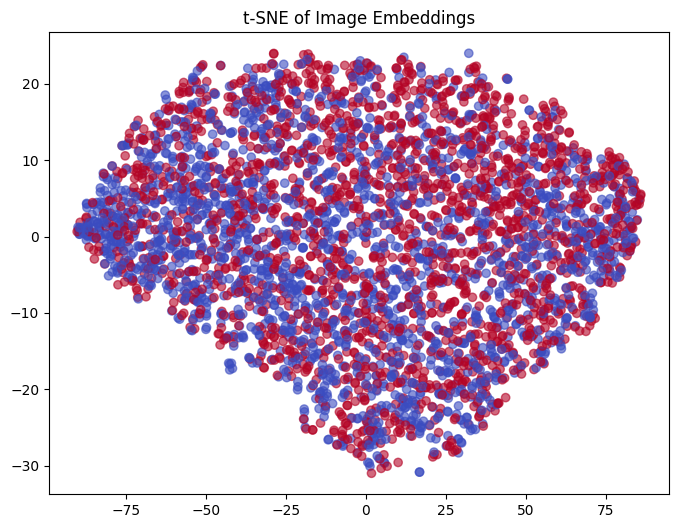

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings from penultimate layer
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feat = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(images))))))))
        feat = torch.flatten(feat, 1)
        embeddings.append(feat.cpu().numpy())
        labels_list.append(labels.numpy())

embeddings = np.vstack(embeddings)
labels_list = np.hstack(labels_list)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels_list, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE of Image Embeddings")
plt.show()

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

# 1️⃣ Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        target = output[0, class_idx]
        target.backward()
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


# 2️⃣ Unnormalization for plotting
inv_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# 3️⃣ Grad-CAM visualization function
def show_gradcam_with_pred(image_tensor, true_label, model, target_layer):
    gradcam = GradCAM(model, target_layer)
    image = image_tensor.unsqueeze(0).to(device)

    # Model prediction
    output = model(image)
    pred_label = output.argmax(dim=1).item()

    cam = gradcam.generate(image, class_idx=pred_label)  # generate heatmap for predicted class

    # Original image for plotting
    orig_img = inv_transform(image_tensor).permute(1,2,0).cpu().numpy()
    orig_img = np.clip(orig_img, 0, 1)

    # Grad-CAM overlay
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.5*heatmap/255 + 0.5*orig_img).clip(0,1)

    # Plot side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title(f"Original\nTrue: {'Real' if true_label==0 else 'Fake'}\nPred: {'Real' if pred_label==0 else 'Fake'}")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Grad-CAM Overlay\nPredicted: {'Real' if pred_label==0 else 'Fake'}")
    plt.show()


In [10]:
# Grab a batch
images, labels = next(iter(test_loader))

# Separate real and fake images
real_indices = [i for i, l in enumerate(labels) if l==0]
fake_indices = [i for i, l in enumerate(labels) if l==1]

real_samples = [images[i] for i in real_indices[:3]]
real_labels = [labels[i].item() for i in real_indices[:3]]

fake_samples = [images[i] for i in fake_indices[:3]]
fake_labels = [labels[i].item() for i in fake_indices[:3]]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


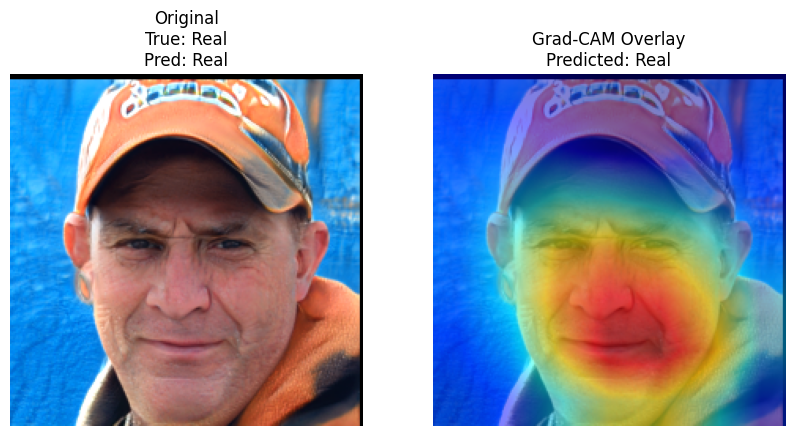

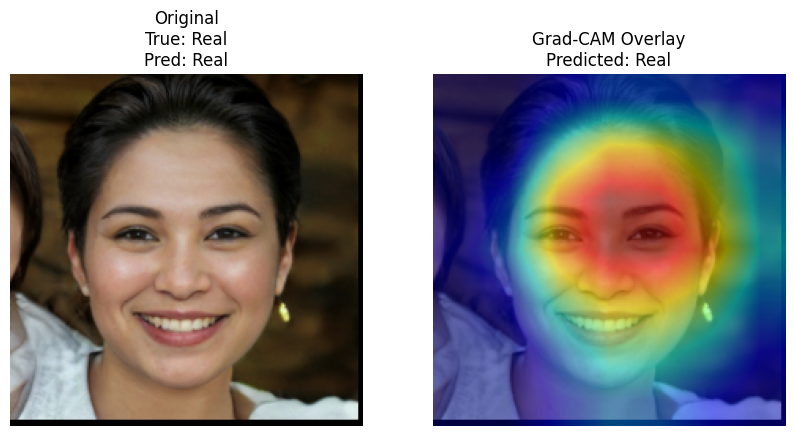

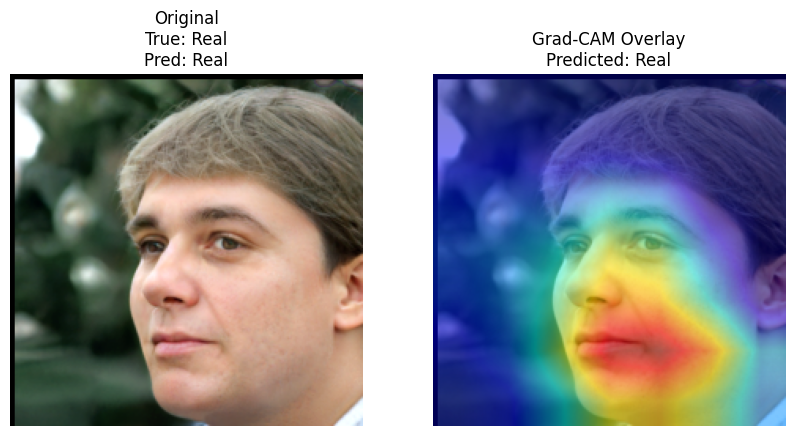

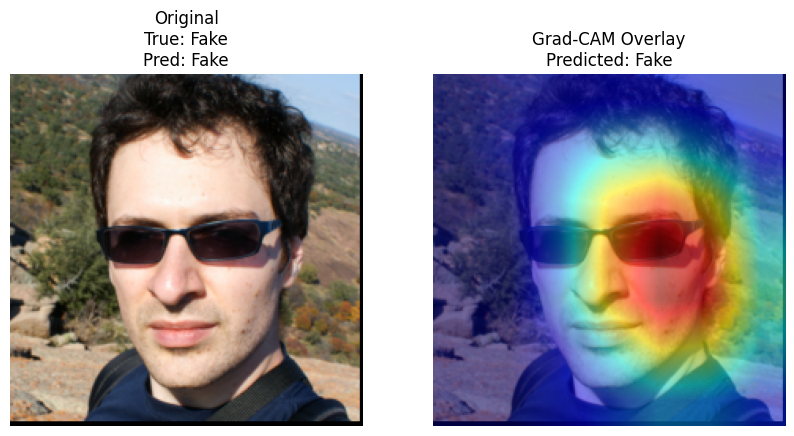

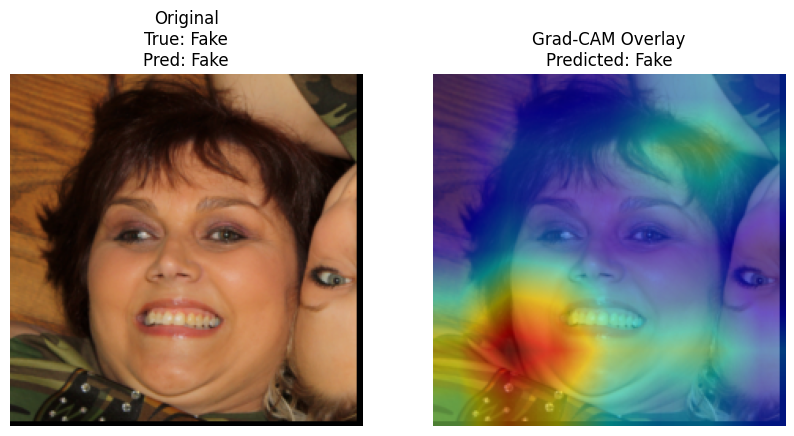

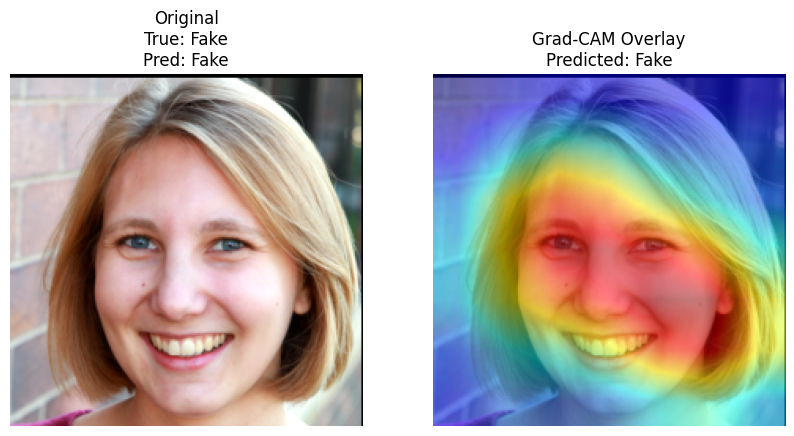

In [11]:
target_layer = model.layer4[-1]  # last conv layer for ResNet
model.eval()

# Real images
for img, lbl in zip(real_samples, real_labels):
    show_gradcam_with_pred(img, lbl, model, target_layer)

# Fake images
for img, lbl in zip(fake_samples, fake_labels):
    show_gradcam_with_pred(img, lbl, model, target_layer)
